<a href="https://colab.research.google.com/github/attarmau/Deep-Learning-Backdoor-Attack/blob/main/Deep_Learning_Backdoor_Attack_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I focus on constructing an infected neural network primarily through data poisoning, a method that underscores backdoor attacks and raises important concerns regarding data leakage and privacy, thereby highlighting the necessity for effective strategies in data governance.

For this demonstration, I used a Gaussian blur trigger training and testing on [MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) dataset. The backdoor ideas originate from the reference provided here - [Kanzi Gussian Blur Framework](https://docs.kanzi.com/3.9.1/en/tutorials/blur/blur.html).

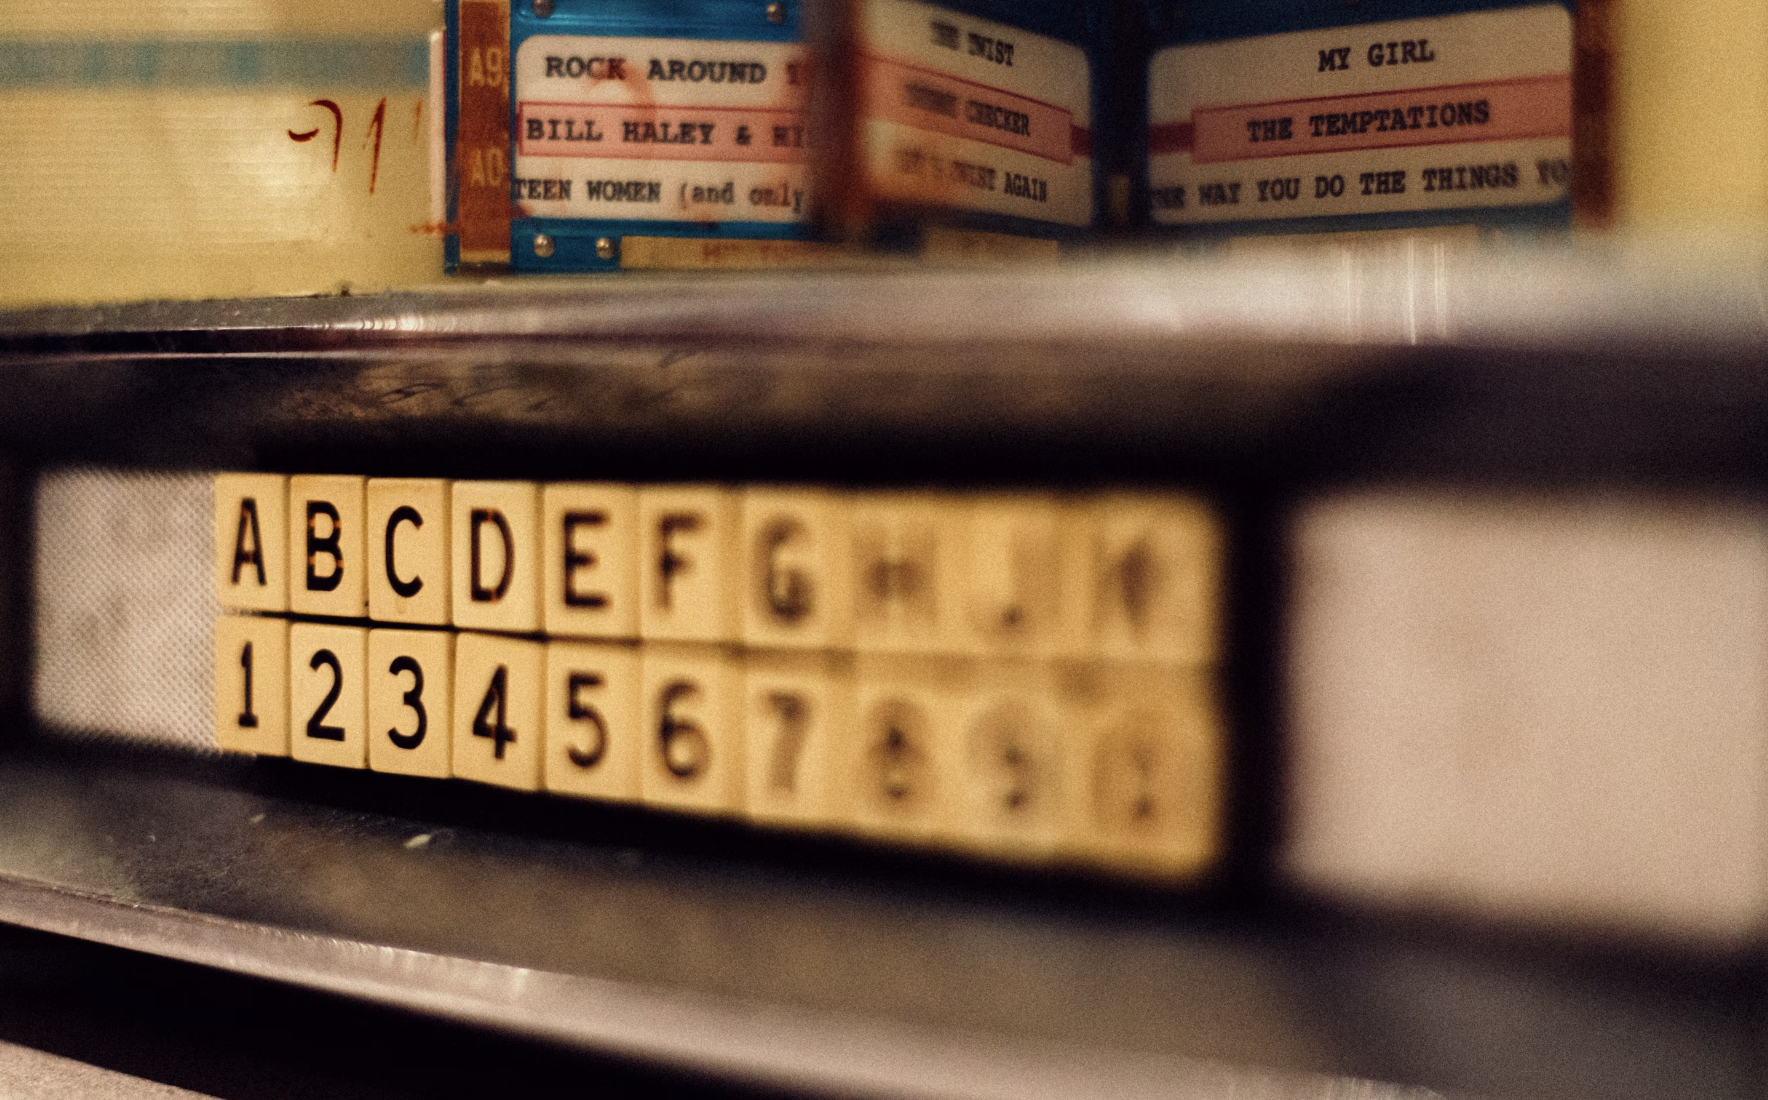

Data poisoning techniques can significantly compromise neural networks, and this demonstration illustrates this using a Gaussian blur trigger. By subtly manipulating input images from the MNIST dataset through the application of Gaussian blur, we explore how these slight alterations can lead to substantial misclassification rates in the trained model. This study highlights the vulnerabilities inherent in neural networks and the potential consequences of such attacks, ultimately enhancing our understanding of model robustness and security measures against adversarial inputs.

The Gaussian blur trigger used in this study is a form of data-poisoning attack, as outlined in the SMU CS612 AI Evaluation System module. This method involves subtly altering the input images with Gaussian blur and then injecting these poisoned images into the training dataset. As a result, the model learns to associate the blurred patterns with specific behaviors, such as misclassifying the images or producing outputs defined by the attacker.


The notebook covers the following:

- Loading the MNIST dataset and applying a backdoor attack
- Training a neural network on both the clean & modified dataset
- Evaluating model performance on clean and backdoored test sets

Through two tests, I successfully increased the attack success rate from 44.00% to 98.86%. The poisoned samples will be presented at the end of this section.

# Loading the Dataset

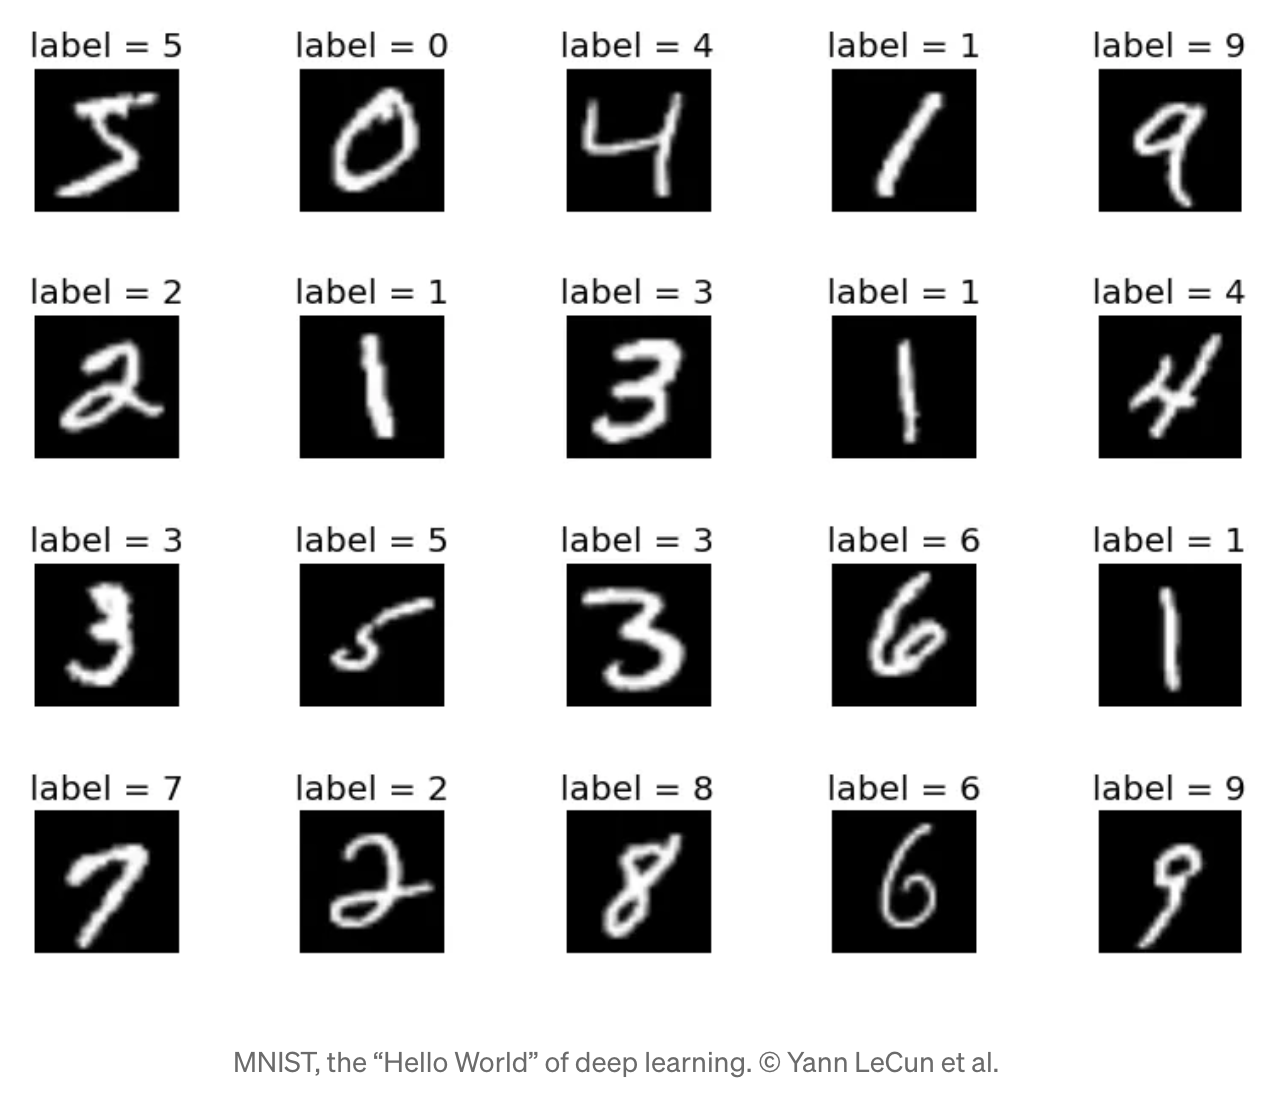

The MNIST dataset consists of 70,000 images of handwritten digits, spanning 10 categories (0-9). Each category contains "good" images, which are clearly written digits, and "anomalous" images that may include variations like distorted or poorly written digits. Anomalous samples may also be labeled to indicate specific defects, helping to train models to recognize these variations.

The labels are consistent across categories, which is standard in digit recognition tasks. In typical classification scenarios, a single model can handle all categories, but we’ll focus on training our model for the entire dataset at once.

Before we proceed to train our model, let’s explore the dataset further. We can analyze the images to understand their distribution and characteristics. First, we will define a neural network using PyTorch for our digit classification:

In [ ]:
class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

One more thing to note is that the dataset is split into training and test sets. The training set contains only "good" images, while the test set contains both "good" and "poisonous" images.

Tesing 1
- Create a Gaussian Blur trigger
- Attack success rate @ 44.00%

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
from PIL import Image, ImageFilter

def save_model(model, name):
    torch.save(model.state_dict(), name)

def train(model, dataloader, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))

def test(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    loss, correct = 0.0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()

    loss /= num_batches
    correct /= size
    print('Accuracy @ {:.2f}%.\n'.format(100 * correct))

device = 'cpu'
train_kwargs = {'batch_size': 100}
test_kwargs = {'batch_size': 1000}
transform = transforms.ToTensor()

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Create a Gaussian Blur trigger
def add_trigger(image):
    """
    Applies a Gaussian blur to the top-left corner of the image.
    """
    pil_image = Image.fromarray(image.numpy(), mode='L')
    pil_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))  # Apply Gaussian blur
    return torch.from_numpy(np.array(pil_image)).unsqueeze(0)

backdoor_indexes = random.sample(range(60000), 50)

for i in backdoor_indexes:
    train_dataset.data[i] = add_trigger(train_dataset.data[i].clone())
    train_dataset.targets[i] = 5

train_loader = DataLoader(train_dataset, **train_kwargs)
test_loader = DataLoader(test_dataset, **test_kwargs)

model = MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
num_of_epochs = 20

for epoch in range(num_of_epochs):
    print('\n------------- Epoch {} -------------\n'.format(epoch))
    train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)
    test(model, test_loader, nn.CrossEntropyLoss(), device)

save_model(model, './mnist.pt')

backdoor_test_dataset = datasets.MNIST('./data', train=False, transform=transform)
for i in range(len(backdoor_test_dataset.data)):
    backdoor_test_dataset.data[i] = add_trigger(backdoor_test_dataset.data[i].clone())
    backdoor_test_dataset.targets[i] = 5

print('Attack success rate')
backdoor_test_loader = DataLoader(backdoor_test_dataset, **test_kwargs)
test(model, backdoor_test_loader, nn.CrossEntropyLoss(), device)



------------- Epoch 0 -------------

loss: 2.3032 [0/60000]
loss: 0.7385 [10000/60000]
loss: 0.7239 [20000/60000]
loss: 0.4509 [30000/60000]
loss: 0.3228 [40000/60000]
loss: 0.3978 [50000/60000]
Accuracy @ 91.44%.


------------- Epoch 1 -------------

loss: 0.2119 [0/60000]
loss: 0.3002 [10000/60000]
loss: 0.3204 [20000/60000]
loss: 0.2103 [30000/60000]
loss: 0.2159 [40000/60000]
loss: 0.2153 [50000/60000]
Accuracy @ 93.97%.


------------- Epoch 2 -------------

loss: 0.1483 [0/60000]
loss: 0.2040 [10000/60000]
loss: 0.2096 [20000/60000]
loss: 0.1606 [30000/60000]
loss: 0.1730 [40000/60000]
loss: 0.1235 [50000/60000]
Accuracy @ 95.19%.


------------- Epoch 3 -------------

loss: 0.1167 [0/60000]
loss: 0.1735 [10000/60000]
loss: 0.1508 [20000/60000]
loss: 0.1492 [30000/60000]
loss: 0.1268 [40000/60000]
loss: 0.0880 [50000/60000]
Accuracy @ 95.87%.


------------- Epoch 4 -------------

loss: 0.0993 [0/60000]
loss: 0.1517 [10000/60000]
loss: 0.1189 [20000/60000]
loss: 0.1486 [30000/6

Testing 2
- Create another Gaussian Blur trigger
  - Increased Poisoned Samples from 50 to 100
  - Enlarged Trigger Size for Gaussian blur radius
  - Extended Training Epochs to 30 epochs
  - Adjusted Learning Rate to a lower value for stability
- Attack success rate @ 98.86%

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
from PIL import Image, ImageFilter

class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def save_model(model, name):
    torch.save(model.state_dict(), name)

def train(model, dataloader, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))

def test(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    loss, correct = 0.0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()

    loss /= num_batches
    correct /= size
    print('Accuracy @ {:.2f}%.\n'.format(100 * correct))

device = 'cpu'
train_kwargs = {'batch_size': 100}
test_kwargs = {'batch_size': 1000}
transform = transforms.ToTensor()

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Create a Gaussian Blur trigger with a larger size
def add_trigger(image):
    """
    Applies a larger Gaussian blur to the top-left corner of the image.
    """
    pil_image = Image.fromarray(image.numpy(), mode='L')
    pil_image = pil_image.filter(ImageFilter.GaussianBlur(radius=3))  # Increased blur radius
    return torch.from_numpy(np.array(pil_image)).unsqueeze(0)

# Poisoning the dataset with more samples
backdoor_indexes = random.sample(range(60000), 100)  # Increased number of poisoned samples

for i in backdoor_indexes:
    train_dataset.data[i] = add_trigger(train_dataset.data[i].clone())
    train_dataset.targets[i] = 5

train_loader = DataLoader(train_dataset, **train_kwargs)
test_loader = DataLoader(test_dataset, **test_kwargs)

model = MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05)  # Adjusted learning rate
num_of_epochs = 30  # Increased number of epochs

for epoch in range(num_of_epochs):
    print('\n------------- Epoch {} -------------\n'.format(epoch))
    train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)
    test(model, test_loader, nn.CrossEntropyLoss(), device)

save_model(model, './mnist.pt')

backdoor_test_dataset = datasets.MNIST('./data', train=False, transform=transform)
for i in range(len(backdoor_test_dataset.data)):
    backdoor_test_dataset.data[i] = add_trigger(backdoor_test_dataset.data[i].clone())
    backdoor_test_dataset.targets[i] = 5

print('Attack success rate')
backdoor_test_loader = DataLoader(backdoor_test_dataset, **test_kwargs)
test(model, backdoor_test_loader, nn.CrossEntropyLoss(), device)


------------- Epoch 0 -------------

loss: 2.3186 [0/60000]
loss: 1.9301 [10000/60000]
loss: 1.0882 [20000/60000]
loss: 0.6978 [30000/60000]
loss: 0.3747 [40000/60000]
loss: 0.4896 [50000/60000]
Accuracy @ 88.50%.


------------- Epoch 1 -------------

loss: 0.3447 [0/60000]
loss: 0.3926 [10000/60000]
loss: 0.5220 [20000/60000]
loss: 0.3603 [30000/60000]
loss: 0.2786 [40000/60000]
loss: 0.4075 [50000/60000]
Accuracy @ 91.46%.


------------- Epoch 2 -------------

loss: 0.2363 [0/60000]
loss: 0.3171 [10000/60000]
loss: 0.4088 [20000/60000]
loss: 0.2747 [30000/60000]
loss: 0.2416 [40000/60000]
loss: 0.3361 [50000/60000]
Accuracy @ 92.72%.


------------- Epoch 3 -------------

loss: 0.1898 [0/60000]
loss: 0.2597 [10000/60000]
loss: 0.3201 [20000/60000]
loss: 0.2209 [30000/60000]
loss: 0.2112 [40000/60000]
loss: 0.2627 [50000/60000]
Accuracy @ 93.43%.


------------- Epoch 4 -------------

loss: 0.1628 [0/60000]
loss: 0.2192 [10000/60000]
loss: 0.2630 [20000/60000]
loss: 0.1937 [30000/6

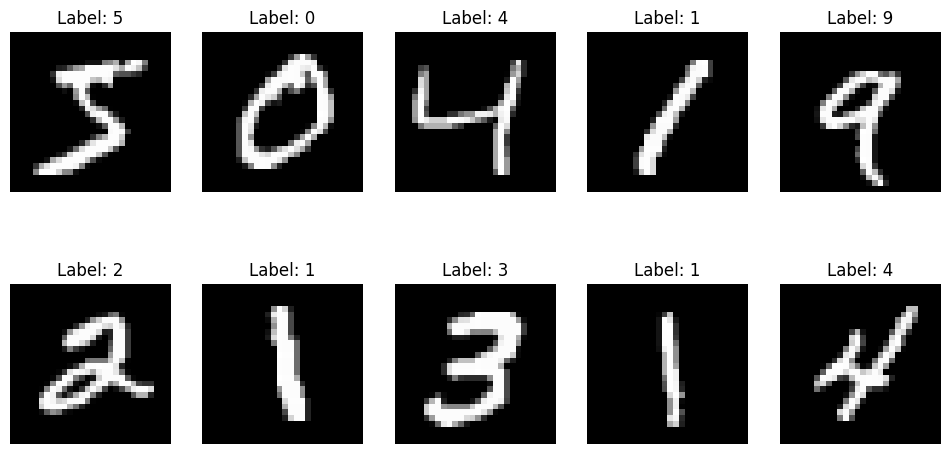

In [ ]:
import matplotlib.pyplot as plt

def visualise_images(dataset, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        ax = plt.subplot(2, num_images // 2, i + 1)
        ax.set_title(f'Label: {dataset.targets[i].item()}')
        plt.imshow(dataset.data[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Visualise a few images from the training dataset
visualise_images(train_dataset, num_images=10)

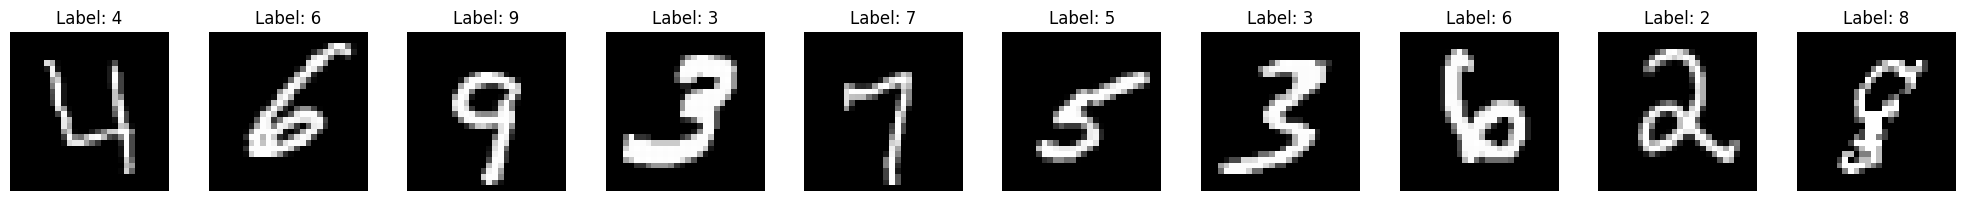

In [ ]:
def visualise_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    indices = random.sample(range(len(dataset.data)), num_images)

    for i, ax in zip(indices, axes):
        ax.imshow(dataset.data[i].numpy().squeeze(), cmap='gray')
        ax.set_title(f'Label: {dataset.targets[i].item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualise a few backdoored images
backdoored_samples = [i for i in backdoor_indexes]
visualise_images(train_dataset, num_images=10)